# RL over cLATb for SPECK (ε = 0.1)

Trains a tabular **Q-learning** agent using the **cLATb** structure: `cLATb: { u: { v: { w: bd }}}`.
- **Reward** = `log₂(|bias|)` (piling-up).
- **State** = `(u, v)`, **Action** = `w`.
- **Transition** (SPECK): `u' = ROR(w, α)`, `v' = ROL(v, β) XOR w`.
- **Exploration**: ε-greedy with **ε = 0.1**.

Works in **Colab** (file upload / Drive), Kaggle, or local Jupyter.


In [1]:
import sys
import os, gzip, pickle, math, random
from collections import defaultdict
from typing import Dict, Tuple, List, Optional, Iterable

from collections import defaultdict
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)



## Auto detect the environment and locate and load the cLAT

In [2]:


DEFAULT_NAME = "clat_speck_pruned.pkl.gz"

ENV = {
    "colab": "google.colab" in sys.modules,
    "kaggle": bool(os.environ.get("KAGGLE_KERNEL_RUN_TYPE")),
    "vscode": bool(os.environ.get("VSCODE_PID")),
}
ENV["jupyter_local"] = not any(ENV.values())

def candidate_paths():
    cands = []
    if "CLAT_PATH" in globals():
        cands.append(globals()["CLAT_PATH"])
    cands += [DEFAULT_NAME, f"./{DEFAULT_NAME}"]
    if ENV["colab"]:
        cands += [f"/content/{DEFAULT_NAME}",
                  f"/content/drive/MyDrive/{DEFAULT_NAME}",
                  f"/content/drive/MyDrive/Tesis/{DEFAULT_NAME}"]
    if ENV["kaggle"]:
        cands += [f"/kaggle/working/{DEFAULT_NAME}", f"/kaggle/input/{DEFAULT_NAME}"]
    return cands

def find_first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

cands = candidate_paths()
path = find_first_existing(cands)

# Colab: si no aparece, permitir upload o Drive
if not path and ENV["colab"]:
    try:
        from google.colab import files, drive  # type: ignore
        print("File not found. Choose one:")
        print("  a) Upload now (files.upload)")
        print("  b) Mount Drive and use /content/drive/MyDrive/...")
        choice = "a"  # cambia a "b" si prefieres Drive
        if choice.lower() == "a":
            up = files.upload()
            if up:
                path = list(up.keys())[0]
        else:
            drive.mount("/content/drive")
            path = f"/content/drive/MyDrive/{DEFAULT_NAME}"
    except Exception as e:
        print("Upload/Drive not available:", e)

if not path:
    # glob needs to be imported as well
    import glob
    g = glob.glob(f"**/{DEFAULT_NAME}", recursive=True)
    if g: path = g[0]

if not path:
    raise FileNotFoundError("Could not find the cLAT pickle. "
                            "Place 'clat_speck.pkl.gz' next to this notebook or set CLAT_PATH.\n"
                            "Tried:\n" + "\n".join(cands))

print("ENV:", ENV)
print("Using path:", os.path.abspath(path))

# Cargar pickle (fallback de encoding)
try:
    with gzip.open(path, "rb") as f:
        clat_obj = pickle.load(f)
except Exception:
    with gzip.open(path, "rb") as f:
        clat_obj = pickle.load(f, encoding="latin1")

print("Loaded object type:", type(clat_obj))

# Seleccionar payload que contiene 'cLATb'
if isinstance(clat_obj, dict) and "cLATb" in clat_obj:
    payload = clat_obj
elif isinstance(clat_obj, dict) and "payload" in clat_obj and isinstance(clat_obj["payload"], dict) and "cLATb" in clat_obj["payload"]:
    payload = clat_obj["payload"]
else:
    candidate = None
    if isinstance(clat_obj, dict):
        for v in clat_obj.values():
            if isinstance(v, dict) and "cLATb" in v:
                candidate = v; break
    if candidate is None:
        raise KeyError("Could not find 'cLATb' in the loaded pickle. Inspect the structure and adjust.")
    payload = candidate

assert "cLATb" in payload, "Payload does not contain 'cLATb'."
print("Found keys in payload:", list(payload.keys()))

ENV: {'colab': True, 'kaggle': False, 'vscode': False, 'jupyter_local': False}
Using path: /content/clat_speck_pruned.pkl.gz
Loaded object type: <class 'dict'>
Found keys in payload: ['m', 'cLATmin', 'cLATN', 'cLATu', 'cLATw', 'cLATb']


## SPECK-32 implementation

In [3]:

class Speck:
    def __init__(self, n_rounds=22, word_size=16, use_key_schedule=True, alpha=7, beta=2, m=4):
        self.n_rounds = int(n_rounds)
        self.word_size = int(word_size)
        self.n_words = 2
        self.n_main_key_words = int(m)
        self.n_round_key_words = 1
        self.use_key_schedule = bool(use_key_schedule)
        self.alpha = int(alpha)
        self.beta  = int(beta)
        self.mask_val = (1 << self.word_size) - 1
        # tipos (compat con np):
        self.main_key_word_dtype = np.uint16 if self.word_size == 16 else np.uint32
        self.round_keys = None  # np.array shape (R,1) con palabras de subllave

    # --- Rotaciones ---
    def rol(self, x, r):
        n = self.word_size
        return ((x << r) & ((1 << n) - 1)) | (x >> (n - r))

    def ror(self, x, r):
        n = self.word_size
        return (x >> r) | ((x << (self.word_size - r)) & ((1 << self.word_size) - 1))

    # --- Paridad ---
    @staticmethod
    def parity(x: int) -> int:
        return int(x).bit_count() & 1

    # ============ Ronda ============
    def encrypt_one_round(self, p, k, rc=None):
        """Una ronda: (x,y) -> (x',y'). k es [kw] o (kw,)."""
        x, y = int(p[0]), int(p[1])
        x = self.ror(x, self.alpha)
        x = (x + y) & self.mask_val
        x = x ^ int(k[0])
        y = self.rol(y, self.beta)
        y = y ^ x
        return x, y

    def decrypt_one_round(self, c, k, rc=None):
        """Inversa de una ronda: (x',y') -> (x,y)."""
        x, y = int(c[0]), int(c[1])
        y = y ^ x
        y = self.ror(y, self.beta)
        x = x ^ int(k[0])
        x = (x - y) & self.mask_val
        x = self.rol(x, self.alpha)
        return x, y

    # ============ Full/Reducido ============
    def encrypt(self, plaintext, rounds=None, key=None, trace=False):
        R = self.n_rounds if rounds is None else int(rounds)
        x, y = int(plaintext[0]), int(plaintext[1])
        rk = self.key_schedule(key) if (key is not None) else self.round_keys
        if rk is None:
            raise ValueError("round_keys no inicializadas. Llama key_schedule(key) o pasa key=")
        out = [(x, y)] if trace else None
        for r in range(R):
            x, y = self.encrypt_one_round((x, y), rk[r])
            if trace:
                out.append((x, y))
        return out if trace else (x, y)

    def decrypt(self, ciphertext, rounds=None, key=None, trace=False):
        R = self.n_rounds if rounds is None else int(rounds)
        x, y = int(ciphertext[0]), int(ciphertext[1])
        rk = self.key_schedule(key) if (key is not None) else self.round_keys
        if rk is None:
            raise ValueError("round_keys no inicializadas. Llama key_schedule(key) o pasa key=")
        rk = rk[:R]
        out = [(x, y)] if trace else None
        for r in range(R - 1, -1, -1):
            x, y = self.decrypt_one_round((x, y), rk[r])
            if trace:
                out.append((x, y))
        return out if trace else (x, y)

    # ============ Puntos internos última ronda ============
    def partial_decrypt_last_round(self, C, k_r, stop_at="before_add"):
        """
        Invierte selectivamente la última ronda sobre C=(x',y') usando k_r=[kw].
        stop_at:
          - "after_xor_y"     -> (x', y^)
          - "after_ror_beta"  -> (x', y~~)
          - "after_xor_k"     -> (x^, y~~)
          - "before_add"      -> (x~~, y~~)
          - "after_rol_alpha" -> (x, y) original antes de la última ronda
        """
        x1, y1 = int(C[0]), int(C[1])
        # y = y ^ x
        y = y1 ^ x1
        if stop_at == "after_xor_y":
            return x1, y
        # y = ROR(y, beta)
        y = self.ror(y, self.beta)
        if stop_at == "after_ror_beta":
            return x1, y
        # x = x ^ k
        x = x1 ^ int(k_r[0])
        if stop_at == "after_xor_k":
            return x, y
        # x = (x - y)
        x = (x - y) & self.mask_val
        if stop_at == "before_add":
            return x, y
        # x = ROL(x, alpha)
        x = self.rol(x, self.alpha)
        if stop_at == "after_rol_alpha":
            return x, y
        raise ValueError(f"stop_at desconocido: {stop_at}")

    # ============ Key schedule ============
    def key_schedule(self, key):
        """
        Devuelve np.array shape (n_rounds, 1) con las subllaves.
        'key' como np.array shape (m,1) o lista de m palabras.
        """
        if key is None:
            return self.round_keys
        if isinstance(key, (list, tuple)):
            key = np.array(key, dtype=self.main_key_word_dtype)[:, np.newaxis]
        assert key.shape[0] == self.n_main_key_words, "m (número de palabras de clave) no coincide"
        ks = [0 for _ in range(self.n_rounds)]
        ks[0] = int(key[len(key)-1][0])  # última palabra como k0
        L = list(reversed([int(key[i][0]) for i in range(len(key)-1)]))  # resto invertidas
        for i in range(self.n_rounds - 1):
            L[i % (len(L))], ks[i+1] = self.encrypt_one_round((L[i % len(L)], ks[i]), [i])
        self.round_keys = np.array(ks, dtype=self.main_key_word_dtype)[:, np.newaxis]
        return self.round_keys

    # ============ Correlación exacta de UNA suma (DP de carry) ============
    @staticmethod
    def _corr_addition(a_mask, b_mask, g_mask, n):
        # correlación exacta en [-1,1] para <a,x> ⊕ <b,y> ⊕ <g, x+y>
        A = [(a_mask>>i)&1 for i in range(n)]
        B = [(b_mask>>i)&1 for i in range(n)]
        G = [(g_mask>>i)&1 for i in range(n)]
        DP0, DP1 = 1, 0  # carry_in = 0/1
        for i in range(n):
            nDP0 = nDP1 = 0
            for cin in (0,1):
                base = DP0 if cin == 0 else DP1
                if base == 0:
                    continue
                for x in (0,1):
                    for y in (0,1):
                        cout = (x & y) | (x & cin) | (y & cin)
                        e = ((A[i]^G[i]) & x) ^ ((B[i]^G[i]) & y) ^ (G[i] & cin)
                        if cout == 0:
                            nDP0 += base if e == 0 else -base
                        else:
                            nDP1 += base if e == 0 else -base
            DP0, DP1 = nDP0, nDP1
        return (DP0 + DP1) / (2**(2*n))

    def corr_one_round_masks(self, ax, ay, gx, gy_prime=0):
        """
        Correlación de 1 ronda con máscaras (teórica):
        ax, ay: máscaras de entrada; gx: máscara en x' (XOR k no cambia corr);
        gy_prime: máscara en y' (opcional).
        """
        n = self.word_size
        a_for_adder = self.rol(ax, self.alpha)
        b_for_adder = ay ^ self.ror(gy_prime, self.beta)
        g_for_adder = gx
        return self._corr_addition(a_for_adder, b_for_adder, g_for_adder, n)

    # ===================================================
    #  (1) Herramientas manuales para triples (u,v,w)
    # ===================================================

    def corr_weight_add(self, u, v, w):
        """
        Devuelve Cw (entero) si (u,v,w) es válida para la suma n-bit; None si no lo es.
        Filtro de validez usa máscara Z (bits con acarreo).
        """
        n = self.word_size
        A = u ^ v
        B = u ^ w
        C = u ^ v ^ w
        cw = 0
        Z  = 0
        carry = 0
        for i in range(n):  # LSB→MSB
            cbit = (C >> i) & 1
            carry = (cbit + carry) & 1
            if carry:
                cw += 1
                Z |= (1 << i)
        if (A & ~Z) != 0:
            return None
        if (B & ~Z) != 0:
            return None
        return cw

    def next_round_masks(self, GX_i, GY_i, w):
        """
        Dadas GX_i, GY_i y elección de w = GX_{i+1}, produce:
          triple=(u,v,w)  y  siguiente estado (GX_{i+1}, GY_{i+1}).
        Reglas SPECK:
          u = ROR(GX_i, alpha),  v = GY_i,
          GY_{i+1} = ROL(GY_i, beta) ^ GX_{i+1}.
        """
        u = self.ror(GX_i, self.alpha)
        v = GY_i
        GX_ip1 = w
        GY_ip1 = self.rol(GY_i, self.beta) ^ GX_ip1
        return (u, v, GX_ip1), (GX_ip1, GY_ip1)

    def trail_weight(self, triples):
        total = 0
        for (u, v, w) in triples:
            cw = self.corr_weight_add(u, v, w)
            if cw is None:
                return None
            total += cw
        return total  # |corr| = 2^{-total}

    def greedy_trail(self, GX0, GY0, rounds=6, force_w_last=None, allow_trivial=False,
                 consider_three_bits_if_empty=False):
      """
      Greedy simple pero EXHAUSTIVO en 1–2 bits por ronda.
      - force_w_last: fija w en la última ronda (útil para anclar un gx).
      - allow_trivial: permite u=v=w (Cw=0). Déjalo False salvo diagnóstico.
      - consider_three_bits_if_empty: si no hay ningún 1–2 bits válido, prueba 3 bits.
      Devuelve (triples, GX_list, GY_list, Cw_total) o (None, GX, GY, None) si falla.
      """
      n = self.word_size
      M = self.mask_val
      GX = [0] * (rounds + 1)
      GY = [0] * (rounds + 1)
      GX[0], GY[0] = (int(GX0) & M), (int(GY0) & M)

      triples = []
      total_cw = 0

      for r in range(rounds):
          u = self.ror(GX[r], self.alpha) & M
          v = GY[r] & M

          # Construye lista completa de 1–2 bits
          cand_ws = []
          for i in range(n):
              cand_ws.append((1 << i) & M)
          for i in range(n):
              for j in range(i+1, n):
                  cand_ws.append(((1 << i) | (1 << j)) & M)

          # Si es la última ronda y se pide ancla, solo ese w
          if (force_w_last is not None) and (r == rounds - 1):
              cand_ws = [int(force_w_last) & M]

          best = None
          best_cw = None

          for w in cand_ws:
              triple = (u, v, w)
              cw = self.corr_weight_add(*triple)
              if cw is None:
                  continue
              if (not allow_trivial) and (u == v == w):
                  continue
              if (best_cw is None) or (cw < best_cw):
                  best_cw = cw
                  best = (triple, w)

          # Si no hubo ningún 1–2 bits válido, intenta 3 bits (opcional)
          if (best is None) and consider_three_bits_if_empty:
              for i in range(n):
                  for j in range(i+1, n):
                      for k in range(j+1, n):
                          w = ((1<<i)|(1<<j)|(1<<k)) & M
                          triple = (u, v, w)
                          cw = self.corr_weight_add(*triple)
                          if cw is None:
                              continue
                          if (not allow_trivial) and (u == v == w):
                              continue
                          if (best_cw is None) or (cw < best_cw):
                              best_cw = cw
                              best = (triple, w)

          if best is None:
              return None, GX, GY, None

          triple, w_best = best
          GX[r+1] = w_best
          GY[r+1] = (self.rol(GY[r], self.beta) ^ w_best) & M
          triples.append(triple)
          total_cw += best_cw

      return triples, GX, GY, total_cw

    def gen_pairs(self, Npairs, rounds=None, seed=1234):
        """Genera Npairs de (P,C) cifrando con las round_keys cargadas."""
        if self.round_keys is None:
            raise ValueError("round_keys no inicializadas. Llama key_schedule(key)." )
        rng = np.random.default_rng(seed)
        n = self.word_size
        m = (1 << n) - 1
        R = self.n_rounds if rounds is None else int(rounds)
        out = []
        for _ in range(int(Npairs)):
            P = (int(rng.integers(0, 1<<n)) & m, int(rng.integers(0, 1<<n)) & m)
            C = self.encrypt(P, rounds=R, key=None, trace=False)
            out.append((P, C))
        return out

    def _mask_bit_positions(self, w):
        n = self.word_size
        return [i for i in range(n) if (w >> i) & 1]

    def matsui1_last_round_score_keyed(self, pairs, ax, ay, gx, gy_prime=0, w_last=None):
        """Matsui-1 'keyed' para la ÚLTIMA ronda"""
        n = self.word_size

        if w_last is None:
            w_last = gx
        if w_last == 0:
            raise ValueError("w_last es 0: no hay bits de clave para adivinar.")

        bitpos = [i for i in range(n) if (w_last >> i) & 1]
        scores = {}

        for g in range(1 << len(bitpos)):
            key_guess = 0
            for j, pos in enumerate(bitpos):
                if (g >> j) & 1:
                    key_guess |= (1 << pos)

            bias_counter = 0
            for (_, C) in pairs:
                x1, y1 = C  # ciphertext (x',y')
                x, y = self.partial_decrypt_last_round(C, [key_guess], stop_at="after_rol_alpha")

                lhs = ( self.parity(x  & ax)
                      ^ self.parity(y  & ay)
                      ^ self.parity(x1 & gx)
                      ^ self.parity(y1 & gy_prime) )
                bias_counter += (lhs == 0) - (lhs == 1)

            scores[key_guess] = abs(bias_counter)

        ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)
        return ranked

    def estimate_bias_of_triple(self, u, v, w, samples=200_000, seed=2025):
        """Muestreo simple para ver p y |eps| de una triple (u,v,w) n-bit."""
        rng = np.random.default_rng(seed)
        n = self.word_size; m = (1<<n)-1
        cnt = 0
        for _ in range(samples):
            X = int(rng.integers(0, 1<<n)) & m
            Y = int(rng.integers(0, 1<<n)) & m
            Z = (X + Y) & m
            lhs = (self.parity(X & u) ^ self.parity(Y & v) ^ self.parity(Z & w))
            cnt += (lhs == 0)
        p = cnt / samples
        eps = abs(p - 0.5)
        return p, eps

    @staticmethod
    def _bits_set_(x: int, n: int):
        """Devuelve posiciones 0..n-1 con bit=1 en x."""
        return [i for i in range(n) if (x >> i) & 1]

    @staticmethod
    def _gen_w_candidates_(n: int, u: int, v: int, max_two_bit_pairs: int | None = None):
        """Genera candidatos w priorizando cercanía a u y v."""
        seen = set()
        order = []

        bu = Speck._bits_set_(u, n)
        bv = Speck._bits_set_(v, n)
        allpos = list(range(n))

        # 1-bit: u -> v -> resto
        for pos in bu + [p for p in bv if p not in bu] + [p for p in allpos if (p not in bu) and (p not in bv)]:
            w = 1 << pos
            if w not in seen:
                seen.add(w); order.append(w)

        # 2-bits cercanos
        pairs = []
        for i in range(len(bu)):
            for j in range(i+1, len(bu)):
                pairs.append((bu[i], bu[j]))
        for i in range(len(bv)):
            for j in range(i+1, len(bv)):
                pairs.append((bv[i], bv[j]))
        for i in bu:
            for j in bv:
                if i != j:
                    a, b = (i, j) if i < j else (j, i)
                    pairs.append((a, b))
        for i in range(n):
            for j in range(i+1, n):
                pairs.append((i, j))

        seen_pair = set()
        two_bit_ws = []
        for i, j in pairs:
            key = (i, j)
            if key in seen_pair:
                continue
            seen_pair.add(key)
            two_bit_ws.append((1 << i) | (1 << j))
            if (max_two_bit_pairs is not None) and (len(two_bit_ws) >= max_two_bit_pairs):
                break

        for w in two_bit_ws:
            if w not in seen:
                seen.add(w); order.append(w)

        return order


## Build graph from the loaded cLAT

In [4]:
clatb = payload["cLATb"]

# ---------- helpers ----------
def _to_int_mask(x: Any) -> int:
    if isinstance(x, (int, np.integer)):
        return int(x)
    s = str(x).strip()
    if s.startswith("(") and s.endswith(")"):
        s = s[1:-1]
    try:
        return int(s, 0)          # soporta "0x..."
    except Exception:
        return int(float(s))

def _bias_from_cw(cw: Any) -> float:
    # cw es peso de correlación → |bias| = 2^{-cw}
    return float(2.0 ** (-float(cw)))

def _best_bias_from_dicts(dicts: Iterable[dict]) -> float:
    """
    Recibe una colección de dicts tipo {'conn': a, 'cw': 8} o {'bias': 0.03125}
    y devuelve el "mejor" bias:
      - si hay 'cw': el menor cw (sesgo más fuerte)
      - si hay 'bias'/'corr': el de mayor |bias|
    """
    best = None
    have_cw = any('cw' in d for d in dicts)

    if have_cw:
        # elegir el menor cw
        min_cw = None
        for d in dicts:
            if 'cw' in d:
                cw = float(d['cw'])
                if (min_cw is None) or (cw < min_cw):
                    min_cw = cw
        if min_cw is not None:
            return _bias_from_cw(min_cw)

    # si no hubo 'cw', intenta por bias/corr y usa mayor |bias|
    for d in dicts:
        if 'bias' in d:
            val = float(d['bias'])
        elif 'corr' in d:
            val = float(d['corr'])
        elif 'epsilon' in d or 'eps' in d or 'e' in d or 'c' in d:
            for k in ('epsilon', 'eps', 'e', 'c'):
                if k in d:
                    val = float(d[k]); break
        else:
            continue
        if (best is None) or (abs(val) > abs(best)):
            best = val

    if best is None:
        raise ValueError("No se pudo determinar bias en dicts de acciones.")
    return float(best)

def _extract_bias(bd: Any) -> float:
    """
    Acepta:
      - escalar (int/float/np.*)
      - dict plano con 'bias'/'corr' o con 'cw'
      - dict de acciones: {0: {...}, 1: {...}}  -> elige mejor acción
    """
    # escalar
    if isinstance(bd, (int, float, np.floating, np.integer)):
        return float(bd)

    if not isinstance(bd, dict):
        raise ValueError(f"Unexpected 'bd' type: {type(bd)} → {bd!r}")

    # --- caso: dict de acciones (values también son dicts con cw/bias) ---
    if bd and all(isinstance(v, dict) for v in bd.values()) and \
       any(('cw' in v) or ('bias' in v) or ('corr' in v) or ('epsilon' in v) or ('eps' in v) or ('e' in v) or ('c' in v)
           for v in bd.values()):
        return _best_bias_from_dicts(bd.values())

    # --- caso: dict plano con cw/bias ---
    for k in ("bias", "corr", "epsilon", "eps", "e", "c"):
        if k in bd:
            return float(bd[k])
    for k in ("cw", "weight", "cweight", "corr_weight"):
        if k in bd:
            return _bias_from_cw(bd[k])

    # último recurso: primer valor numérico
    for v in bd.values():
        if isinstance(v, (int, float, np.floating, np.integer)):
            return float(v)

    raise ValueError(f"Could not extract bias from bd={bd}")

# ---------- construcción de edges ----------
def build_edges_from_payload(payload: dict):
    # Fuente principal
    src = payload["cLATb"] if "cLATb" in payload else payload["cLATw"]

    edges = defaultdict(list)
    count = 0

    for u, vd in src.items():
        uu = _to_int_mask(u)
        for v, wd in vd.items():
            vv = _to_int_mask(v)

            # wd es mapa w -> bd (bd puede ser: escalar, dict plano, o dict de acciones)
            if isinstance(wd, dict):
                for w, bd in wd.items():
                    ww = _to_int_mask(w)
                    bias = _extract_bias(bd)   # <-- ahora soporta dict de acciones
                    edges[(uu, vv)].append((ww, float(bias)))
                    count += 1
            else:
                # Raro pero lo manejamos: v → bias directo (sin w), asumimos w=0
                ww = 0
                bias = _extract_bias(wd)
                edges[(uu, vv)].append((ww, float(bias)))
                count += 1

    return edges, count

# ---------- uso ----------
edges, count = build_edges_from_payload(payload)
print(f"Built edges for {len(edges)} (u,v) states with {count} transitions total.")
peek_key = next(iter(edges))
print("Sample state:", peek_key, "->", edges[peek_key][:3])


Built edges for 65536 (u,v) states with 780994 transitions total.
Sample state: (0, 0) -> [(0, 0.00390625), (1, 0.00390625), (2, 0.00390625)]


In [5]:

def _to_int(x):
    if isinstance(x, (int, np.integer)): return int(x)
    return int(str(x), 0)

def _bias_from_cw(cw, cw_on="epsilon"):
    cw = float(cw)
    return 2.0 ** (-(cw + 1.0)) if cw_on == "epsilon" else 2.0 ** (-cw)

def build_edges_with_b(payload, cw_on="epsilon"):
    # Usa cLATb porque es la que contiene {conn, cw} indexado por 'b'
    src = payload["cLATb"]
    edges_b = defaultdict(list)   # (u,v,b) -> [(w, bias, b_next)]
    count = 0
    for u, vd in src.items():
        uu = _to_int(u)
        for v, wd in vd.items():
            vv = _to_int(v)
            for w, bd in wd.items():
                ww = _to_int(w)
                # bd es dict indexado por b: {0:{conn,cw}, 1:{conn,cw}} (a veces falta uno)
                for b_key, rec in bd.items():
                    b = int(b_key)
                    cw = rec.get("cw", payload["m"])
                    conn = int(rec.get("conn", 0))  # b_next
                    bias = _bias_from_cw(cw, cw_on=cw_on)
                    edges_b[(uu, vv, b)].append((ww, float(bias), conn))
                    count += 1
    return edges_b, count

edges_b, count = build_edges_with_b(payload, cw_on="epsilon")
print(f"Built edges_b for {len(edges_b)} (u,v,b) states with {count} transitions.")
peek = next(iter(edges_b))
print("Sample:", peek, "->", edges_b[peek][:3])


Built edges_b for 87382 (u,v,b) states with 781250 transitions.
Sample: (0, 0, 0) -> [(0, 0.001953125, 0)]


## Environment

In [6]:
speck = Speck(n_rounds=22, word_size=16, alpha=7, beta=2, m=4)
WORD_BITS = speck.word_size
ALPHA     = speck.alpha
BETA      = speck.beta
MASK      = speck.mask_val

# ========= Utils =========
import math, random
from collections import defaultdict

def _get(d, k):  # soporta claves int/str en el pickle
    return d[k] if k in d else d[str(k)]

def _bias_from_cw(cw: float) -> float:
    # si cw es sobre correlación: |ε|=2^{-cw} ⇒ |bias|=|ε|/2 = 2^{-(cw+1)}
    return 2.0 ** (-(float(cw) + 1.0))


# ========= Entorno jerárquico 8→16 =========
# Estado: (uH, uL, vH, vL, b, phase)  con phase∈{0,1} (elige wH y luego wL)
# Acción: w8 (0..255)
# Recompensa por ronda: |bias| con bias = 2^{-(cwH+cwL+1)}
# === reemplaza tu clase por esta versión (cambia solo reset + helper) ===
class EnvHier8to16:
    def __init__(self, payload: dict, speck16, rounds: int = 6,
                 reward_mode: str = "abs", carry: str = "zero"):
        self.P = payload; self.S = speck16
        self.R = int(rounds); self.reward_mode = reward_mode
        assert carry in ("zero","propagate")
        self.carry = carry
        self._rng = random.Random()
        self.reset()

    def _get(self, d, k):
        return d[k] if k in d else d[str(k)]

    def _row_for(self, u: int, v: int):
        try:
            return self._get(self._get(self.P["cLATb"], u), v)
        except Exception:
            return {}

    def _sample_valid_state(self, trials=5000):
        """Devuelve (uH,uL,vH,vL,b,phase) con al menos 1 acción válida en phase=0."""
        cN = self.P["cLATN"]; cU = self.P["cLATu"]; cW = self.P["cLATw"]; cB = self.P["cLATb"]
        def get(d,k): return d[k] if k in d else d[str(k)]
        for _ in range(trials):
            v16 = self._rng.randrange(1<<16)
            vH, vL = (v16>>8)&0xFF, v16&0xFF
            b = 0  # arrancamos con b_in=0

            # Elegir (uH, wH) válidos para (vH,b=0)
            nh = get(get(cN, vH), b)
            if not nh:
                continue
            # coge un cw al azar y uno de sus índices
            cwHk = self._rng.choice(list(nh.keys()))
            uH_list = get(get(get(cU, vH), b), cwHk)
            wH_list = get(get(get(cW, vH), b), cwHk)
            idxH = self._rng.randrange(len(uH_list))
            uH = int(uH_list[idxH]); wH = int(wH_list[idxH])

            # bH (carry entre mitades)
            bH = int(get(get(get(get(cB, uH), vH), wH), b)["conn"])

            # Chequear que exista al menos un wL válido para (uL, vL, bH)
            nl = get(get(cN, vL), bH)
            if not nl:
                continue
            cwLk = self._rng.choice(list(nl.keys()))
            uL_list = get(get(get(cU, vL), bH), cwLk)
            if not uL_list:
                continue
            uL = int(self._rng.choice(list(uL_list)))

            # ¡Listo! hay acción en phase=0
            return (uH, uL, vH, vL, 0, 0)
        # Si no encontramos en trials, cae a (0,0,0,0) pero con phase=0 sin acciones
        return (0,0,0,0,0,0)

    # --- API ---
    def reset(self, init_state=None):
        self.t = 0
        if init_state is None:
            self.uH, self.uL, self.vH, self.vL, self.b, self.phase = self._sample_valid_state()
        else:
            self.uH, self.uL, self.vH, self.vL, self.b, self.phase = init_state
        self.partial = None
        return (self.uH, self.uL, self.vH, self.vL, self.b, self.phase)

    def actions(self, s=None):
        uH,uL,vH,vL,b,phase = (s if s is not None else
                               (self.uH,self.uL,self.vH,self.vL,self.b,self.phase))
        if phase == 0:
            row = self._row_for(uH, vH)
            return [w for w, bd in row.items() if b in bd]
        else:
            assert self.partial is not None, "Fase baja sin parcial"
            bH = self.partial[2]
            row = self._row_for(uL, vL)
            return [w for w, bd in row.items() if bH in bd]

    def step(self, w: int):
        if self.phase == 0:
            bd = self._row_for(self.uH, self.vH).get(w, {})
            rec = bd.get(self.b)
            if rec is None:
                return (self.uH,self.uL,self.vH,self.vL,self.b,self.phase), -1e2, True, {"error":"invalid_action_hi"}
            cwH = int(rec["cw"]); bH = int(rec["conn"])
            self.partial = (w, cwH, bH)
            self.phase = 1
            return (self.uH,self.uL,self.vH,self.vL,self.b,self.phase), 0.0, False, {"phase":"lo"}

        # phase == 1
        wH, cwH, bH = self.partial
        bd = self._row_for(self.uL, self.vL).get(w, {})
        rec = bd.get(bH)
        if rec is None:
            return (self.uH,self.uL,self.vH,self.vL,self.b,self.phase), -1e2, True, {"error":"invalid_action_lo"}

        cwL = int(rec["cw"]); cw = cwH + cwL
        bias = 2.0 ** (-(float(cw) + 1.0))
        reward = abs(bias) if self.reward_mode == "abs" else math.log2(max(abs(bias), 1e-300))

        w16 = ((wH & 0xFF) << 8) | (w & 0xFF)
        v16 = ((self.vH & 0xFF) << 8) | (self.vL & 0xFF)
        up = self.S.ror(w16, self.S.alpha) & self.S.mask_val
        vp = (self.S.rol(v16, self.S.beta) ^ w16) & self.S.mask_val

        self.uH, self.uL = (up >> 8) & 0xFF, up & 0xFF
        self.vH, self.vL = (vp >> 8) & 0xFF, vp & 0xFF
        self.b = (self.partial[2] if self.carry == "propagate" else 0)
        self.phase = 0
        self.t += 1

        done = (self.t >= self.R) or (len(self.actions()) == 0)
        return (self.uH,self.uL,self.vH,self.vL,self.b,self.phase), reward, done, {
            "cw_round": cw, "bias_round": bias, "w16": w16
        }



In [7]:
R_ROUNDS   = 6
env   = EnvHier8to16(payload, speck, rounds=R_ROUNDS, reward_mode="abs", carry="zero")
s = env.reset()
print("Init state:", s)
print("Phase:", s[-1], " | #actions:", len(env.actions(s)))
a = random.choice(env.actions(s))
s2, r, done, info = env.step(a)
print("After 1st step → phase:", s2[-1], " reward:", r, " done:", done)
if s2[-1] == 1:
    a2 = random.choice(env.actions(s2))
    s3, r2, done2, info2 = env.step(a2)
    print("Closed round → reward:", r2, " done:", done2, " info:", info2)


Init state: (85, 253, 91, 159, 0, 0)
Phase: 0  | #actions: 6
After 1st step → phase: 1  reward: 0.0  done: False
Closed round → reward: 7.62939453125e-06  done: True  info: {'cw_round': 16, 'bias_round': 7.62939453125e-06, 'w16': 32379}


## Agent

In [8]:
import math, random, pickle, numpy as np
from collections import defaultdict

# ========= Agente Q-learning (tabular) =========
class QAgent:
    def __init__(self, epsilon=0.25, alpha=0.30, gamma=1.0):
        self.Q = defaultdict(lambda: defaultdict(float))
        self.epsilon=float(epsilon); self.alpha=float(alpha); self.gamma=float(gamma)

    def policy(self, s, actions):
        if not actions: return None
        if random.random() < self.epsilon:
            return random.choice(actions)     # acción = w8
        qs = self.Q[s]
        return max(actions, key=lambda a: (qs[a], random.random()))

    def update(self, s, a, r, s_next, next_actions):
        qsa = self.Q[s][a]
        max_next = max((self.Q[s_next][ap] for ap in next_actions), default=0.0)
        self.Q[s][a] = qsa + self.alpha * (r + self.gamma*max_next - qsa)

# ========= Hiperparámetros =========
EPISODES   = 5000
R_ROUNDS   = 6
MAX_STEPS  = 2 * R_ROUNDS   # <- clave para el entorno jerárquico
EPSILON0   = 0.35
ALPHA_Q    = 0.30
GAMMA      = 1.0
SEED       = 1337

random.seed(SEED); np.random.seed(SEED)

env   = EnvHier8to16(payload, speck, rounds=R_ROUNDS, reward_mode="abs", carry="zero")
agent = QAgent(epsilon=EPSILON0, alpha=ALPHA_Q, gamma=GAMMA)

returns, best_ret, best_path = [], -1e9, None

for ep in range(1, EPISODES+1):
    s = env.reset()
    total = 0.0
    path  = [s]

    for _ in range(MAX_STEPS):
        acts = env.actions(s)
        if not acts: break
        a = agent.policy(s, acts)
        s_next, r, done, info = env.step(a)
        total += r
        agent.update(s, a, r, s_next, env.actions(s_next))
        s = s_next
        path.append(s)
        if done: break

    returns.append(total)
    if total > best_ret:
        best_ret, best_path = total, path

    # Decaimiento más lento con piso real
    agent.epsilon = max(0.15, agent.epsilon * 0.997)

    if ep % 400 == 0:
        agent.epsilon = max(agent.epsilon, 0.25)
    # ================================================

    if ep % 500 == 0:
        avg500 = float(np.mean(returns[-500:])) if len(returns) >= 500 else float(np.mean(returns))
        print(f"Episode {ep}/{EPISODES}  avg(last500)={avg500:.4f}  best={best_ret:.4f}  eps={agent.epsilon:.3f}")


# Guardar Q-Table
with open("qtable_hier_8to16.pkl","wb") as f:
    pickle.dump({str(k): dict(v) for k, v in agent.Q.items()}, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved Q-table to qtable_hier_8to16.pkl")
print("Best return:", best_ret, " best path length:", len(best_path))


Episode 500/5000  avg(last500)=0.0000  best=0.0000  eps=0.185
Episode 1000/5000  avg(last500)=0.0000  best=0.0000  eps=0.150
Episode 1500/5000  avg(last500)=0.0000  best=0.0000  eps=0.150
Episode 2000/5000  avg(last500)=0.0000  best=0.0000  eps=0.250
Episode 2500/5000  avg(last500)=0.0000  best=0.0000  eps=0.185
Episode 3000/5000  avg(last500)=0.0000  best=0.0000  eps=0.150
Episode 3500/5000  avg(last500)=0.0000  best=0.0000  eps=0.150
Episode 4000/5000  avg(last500)=0.0000  best=0.0000  eps=0.250
Episode 4500/5000  avg(last500)=0.0000  best=0.0000  eps=0.185
Episode 5000/5000  avg(last500)=0.0000  best=0.0000  eps=0.150
Saved Q-table to qtable_hier_8to16.pkl
Best return: 4.57763671875e-05  best path length: 13


## Learning curve

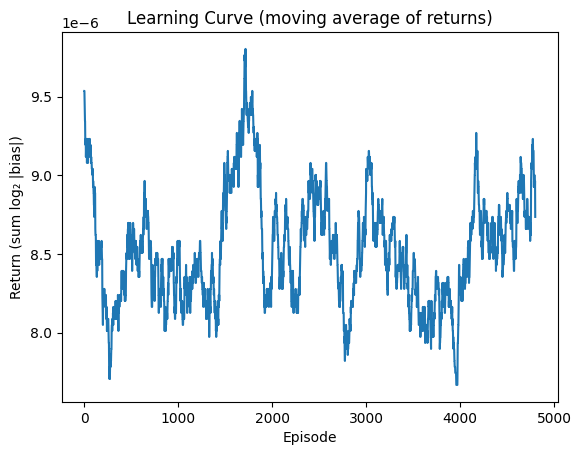

In [9]:
if 'returns' in globals() and returns:
    plt.figure()
    w = min(200, len(returns))
    ma = np.convolve(returns, np.ones(w)/w, mode='valid')
    plt.plot(ma)
    plt.title("Learning Curve (moving average of returns)")
    plt.xlabel("Episode"); plt.ylabel("Return (sum log₂ |bias|)")
    plt.show()
else:
    print("Nada que graficar aún.")
